# Example of validation routine using CAMS Rad BSRN solar radiation data

*Date: May 14th, 2020*

<br>

###  1. Import python modules
***
First import the necessary modules:

In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import numpy as np
import sys
sys.path.append('./python_functions')
import wps
import SeabornFig2Grid
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF

### 2. Load dataframe including measurements and sun position information
***

In [2]:
%%time
SolarDF=pd.read_pickle('./tmpData/car_data_QC.pkl') # load the DataFrame in the Pandas pickle format
Latitude = 44.083
Longitude = 5.059
Elevation = 100.0

SolarDF.head()

Wall time: 578 ms


,GHI,BNI,DHI,DELTA,OMEGA,EOT,THETA_Z,GAMMA_S0,ALPHA_S,R,TOA,TOANI,SR_h,SS_h,QCFlag
2004-01-01 00:01:00,0.0,0.0,0.0,-0.402691,55232.419717,-2.919678,2.769144,-1.198348,0.201574,0.983459,0.0,1413.370532,7.821511,16.755700,True
2004-01-01 00:02:00,0.0,0.0,0.0,-0.402690,55232.424078,-2.919678,2.768499,-1.197703,0.212449,0.983459,0.0,1413.370557,7.821507,16.755704,True
2004-01-01 00:03:00,0.0,0.0,0.0,-0.402689,55232.428440,-2.919678,2.767821,-1.197025,0.223290,0.983459,0.0,1413.370582,7.821503,16.755708,True
2004-01-01 00:04:00,0.0,0.0,0.0,-0.402688,55232.432802,-2.919678,2.767110,-1.196313,0.234097,0.983459,0.0,1413.370607,7.821498,16.755712,True
2004-01-01 00:05:00,0.0,0.0,0.0,-0.402687,55232.437164,-2.919678,2.766366,-1.195569,0.244867,0.983459,0.0,1413.370632,7.821494,16.755717,True


### 3. Temporal aggregation of the measurement (15min)
***

In [3]:
%%time
SolarDF_15min = SolarDF[['GHI','DHI','BNI','THETA_Z','ALPHA_S','TOA','TOANI','QCFlag']].resample('15min').mean()
SolarDF_15min.index=SolarDF_15min.index+dt.timedelta(minutes=15)
SolarDF_15min.head()

Wall time: 250 ms


,GHI,DHI,BNI,THETA_Z,ALPHA_S,TOA,TOANI,QCFlag
2004-01-01 00:15:00,0.0,0.0,0.0,2.764102,0.271287,0.0,1413.370695,1.0
2004-01-01 00:30:00,0.0,0.0,0.0,2.748639,0.420627,0.0,1413.371060,1.0
2004-01-01 00:45:00,0.0,0.0,0.0,2.726423,0.563053,0.0,1413.371437,1.0
2004-01-01 01:00:00,0.0,0.0,0.0,2.698814,0.691800,0.0,1413.371814,1.0
2004-01-01 01:15:00,0.0,0.0,0.0,2.666785,0.807028,0.0,1413.372191,1.0


### 3. Download CAMS Rad data and merge the data to the dataframe
***
downloading the data using the wps

In [6]:
%%time

#%% load and add CAMS Rad to the DF
from urllib.request import urlopen
location = [Latitude, Longitude, Elevation]
date_begin=SolarDF.index.to_pydatetime().min()
date_end=SolarDF.index.to_pydatetime().max()
dt60_to_duration = {1: "PT01M", 15: "PT15M", 60: "PT01H", 1440: "P01D"}
email='alexandre.boilley@transvalor.com'
DT=15./60
str_wps = 'http://www.soda-is.com/service/wps?Service=WPS&Request=Execute&Identifier=get_cams_radiation&version=1.0.0&RawDataOutput=irradiation&DataInputs='
datainputs_wps = 'latitude={:.6f};longitude={:.6f};altitude={:.1f};date_begin={};date_end={};time_ref=UT;summarization={};username={}'\
	.format(location[0], location[1], location[2],date_begin.strftime('%Y-%m-%d'),date_end.strftime('%Y-%m-%d'),dt60_to_duration.get(int(DT*60),"PT60M"),email.replace("@","%2540"));
response = urlopen('{}{}'.format(str_wps,datainputs_wps))
CAMS = pd.read_csv(response,delimiter='[;,/]',comment='#',header=None,names=['T1','T2','TOA','CLEAR_SKY_GHI', 'CLEAR_SKY_BHI', 'CLEAR_SKY_DHI', 'CLEAR_SKY_BNI', 'GHI', 'BHI','DHI','BNI','Reliability'],engine='python')
#CAMS=wps.wps_CAMS_RAD(location,date_begin,date_end,1./60,'alexandre.boilley@transvalor.com')

# set the time corresponding to the end of the interval as index of CAMS
CAMS.set_index('T2',inplace=True)

CAMS.head()


Wall time: 25.3 s


,T1,TOA,CLEAR_SKY_GHI,CLEAR_SKY_BHI,CLEAR_SKY_DHI,CLEAR_SKY_BNI,GHI,BHI,DHI,BNI,Reliability
T2,,,,,,,,,,,
2004-02-01T00:15:00.0,2004-02-01T00:00:00.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2004-02-01T00:30:00.0,2004-02-01T00:15:00.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2004-02-01T00:45:00.0,2004-02-01T00:30:00.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2004-02-01T01:00:00.0,2004-02-01T00:45:00.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2004-02-01T01:15:00.0,2004-02-01T01:00:00.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


... convert $Wh/m^2$ to averaged $W/m^2$:

In [7]:
CAMS.TOA=CAMS.TOA*60/15
CAMS.CLEAR_SKY_GHI=CAMS.CLEAR_SKY_GHI*60/15
CAMS.CLEAR_SKY_BHI=CAMS.CLEAR_SKY_BHI*60/15
CAMS.CLEAR_SKY_DHI=CAMS.CLEAR_SKY_DHI*60/15
CAMS.CLEAR_SKY_BNI=CAMS.CLEAR_SKY_BNI*60/15
CAMS.GHI=CAMS.GHI*60/15
CAMS.BHI=CAMS.BHI*60/15
CAMS.DHI=CAMS.DHI*60/15
CAMS.BNI=CAMS.BNI*60/15


... merge SolarDF and CAMS, and add clearness indices:

In [8]:
SolarDF_15min=SolarDF_15min.merge(CAMS, left_index=True, right_index=True,suffixes=('_bsrn','_CAMS'))

SolarDF_15min["GammaS"]=180/np.pi*(np.pi/2-SolarDF_15min.THETA_Z)
SolarDF_15min["KT_cams"]=SolarDF_15min.GHI_CAMS/SolarDF_15min.TOA_bsrn
SolarDF_15min["KT_bsrn"]=SolarDF_15min.GHI_bsrn/SolarDF_15min.TOA_bsrn
SolarDF_15min["Kb_cams"]=SolarDF_15min.BNI_CAMS/SolarDF_15min.TOANI
SolarDF_15min["Kb_bsrn"]=SolarDF_15min.BNI_bsrn/SolarDF_15min.TOANI

SolarDF_15min.head()

,GHI_bsrn,DHI_bsrn,BNI_bsrn,THETA_Z,ALPHA_S,TOA_bsrn,TOANI,QCFlag,GammaS,T1,...,CLEAR_SKY_BNI,GHI_CAMS,BHI,DHI_CAMS,BNI_CAMS,Reliability,KT_cams,KT_bsrn,Kb_cams,Kb_bsrn
2004-02-01 00:15:00,0.0,0.0,0.0,2.671935,0.127163,0.0,1408.006076,1.0,-63.090576,2004-02-01T00:00:00.0,...,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,0.0,0.0
2004-02-01 00:30:00,0.0,0.0,0.0,2.662780,0.262508,0.0,1408.002054,1.0,-62.566062,2004-02-01T00:15:00.0,...,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,0.0,0.0
2004-02-01 00:45:00,0.0,0.0,0.0,2.647612,0.392192,0.0,1407.998033,1.0,-61.696987,2004-02-01T00:30:00.0,...,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,0.0,0.0
2004-02-01 01:00:00,0.0,0.0,0.0,2.626976,0.514278,0.0,1407.994012,1.0,-60.514659,2004-02-01T00:45:00.0,...,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,0.0,0.0
2004-02-01 01:15:00,0.0,0.0,0.0,2.601521,0.627711,0.0,1407.989990,1.0,-59.056179,2004-02-01T01:00:00.0,...,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,0.0,0.0


... and save the data.


In [9]:
SolarDF_15min.to_pickle('./tmpData/ValidData.pkl')

### 4. Computation of error metrics
***



Selection of the data used for the validation:

In [10]:
index=\
    (~np.isnan(SolarDF_15min.TOA_CAMS)) &\
    (SolarDF_15min.TOA_CAMS>(20)) &\
    (~np.isnan(SolarDF_15min.GHI_bsrn)) &\
    (SolarDF_15min.GHI_bsrn > 5) &\
    (~np.isnan(SolarDF_15min.DHI_bsrn)) &\
    (SolarDF_15min.GHI_bsrn > 0) &\
    (~np.isnan(SolarDF_15min.BNI_bsrn)) &\
    (SolarDF_15min.QCFlag>0)&\
    (~np.isnan(SolarDF_15min.GHI_CAMS)) &\
    (~np.isnan(SolarDF_15min.DHI_CAMS)) &\
    (~np.isnan(SolarDF_15min.BNI_CAMS))

np.sum(index)
#np.sum((SolarDF_15min.GHI_bsrn ))

47199

Calculation of different the error metrics:
- reference mean 
- bias
- standard deviation of the error
- MAE
- RMSE
- correlation coefficient

... for the three components of the solar radiation.

In [11]:
dfErrorMEtrics = pd.DataFrame({\
       'Mean of measurements at station kept for validation': \
                               [SolarDF_15min[index].GHI_bsrn.mean(),\
                                SolarDF_15min[index].DHI_bsrn.mean(),\
                                SolarDF_15min[index].BNI_bsrn.mean(),\
                                'W/m2'],\
       'Number of data pairs kept for validation':\
                               [np.sum(index),\
                                np.sum(index),\
                                np.sum(index),\
                                '-'],\
       'Percentage of data pairs kept relative to the number of GHI data >0 in the period':\
                               [100*np.sum(index)/(np.sum(SolarDF_15min.GHI_bsrn>0)),\
                                100*np.sum(index)/(np.sum(SolarDF_15min.GHI_bsrn>0)),\
                                100*np.sum(index)/(np.sum(SolarDF_15min.GHI_bsrn>0)),\
                                '%'],\
       'Bias (positive means overestimation; ideal value is 0)':\
                               [np.mean(SolarDF_15min[index].GHI_CAMS-SolarDF_15min[index].GHI_bsrn),\
                                np.mean(SolarDF_15min[index].DHI_CAMS-SolarDF_15min[index].DHI_bsrn),\
                                np.mean(SolarDF_15min[index].BNI_CAMS-SolarDF_15min[index].BNI_bsrn),\
                                'W/m2'],\
       'Bias relative to the mean of measurements':\
                               [100*np.mean(SolarDF_15min[index].GHI_CAMS-SolarDF_15min[index].GHI_bsrn)/SolarDF_15min[index].GHI_bsrn.mean(),\
                                100*np.mean(SolarDF_15min[index].DHI_CAMS-SolarDF_15min[index].DHI_bsrn)/SolarDF_15min[index].DHI_bsrn.mean(),\
                                100*np.mean(SolarDF_15min[index].BNI_CAMS-SolarDF_15min[index].BNI_bsrn)/SolarDF_15min[index].BNI_bsrn.mean(),\
                                '%'],\
       'Standard deviation (ideal value is 0)':\
                               [np.std(SolarDF_15min[index].GHI_CAMS-SolarDF_15min[index].GHI_bsrn),\
                                np.std(SolarDF_15min[index].DHI_CAMS-SolarDF_15min[index].DHI_bsrn),\
                                np.std(SolarDF_15min[index].BNI_CAMS-SolarDF_15min[index].BNI_bsrn),\
                                'W/m2'],\
       'Relative standard deviation':\
                               [100*np.std(SolarDF_15min[index].GHI_CAMS-SolarDF_15min[index].GHI_bsrn)/SolarDF_15min[index].GHI_bsrn.mean(),\
                                100*np.std(SolarDF_15min[index].DHI_CAMS-SolarDF_15min[index].DHI_bsrn)/SolarDF_15min[index].DHI_bsrn.mean(),\
                                100*np.std(SolarDF_15min[index].BNI_CAMS-SolarDF_15min[index].BNI_bsrn)/SolarDF_15min[index].BNI_bsrn.mean(),\
                                '%'],\
       'Correlation coefficient (ideal value is 1)':\
                               [np.corrcoef(SolarDF_15min[index].GHI_CAMS,SolarDF_15min[index].GHI_bsrn)[0,1],\
                                np.corrcoef(SolarDF_15min[index].DHI_CAMS,SolarDF_15min[index].DHI_bsrn)[0,1],\
                                np.corrcoef(SolarDF_15min[index].BNI_CAMS,SolarDF_15min[index].BNI_bsrn)[0,1],\
                                '-'],\
        'Mean absolute error':\
                               [np.mean(np.abs(SolarDF_15min[index].GHI_CAMS-SolarDF_15min[index].GHI_bsrn)),\
                                np.mean(np.abs(SolarDF_15min[index].DHI_CAMS-SolarDF_15min[index].DHI_bsrn)),\
                                np.mean(np.abs(SolarDF_15min[index].BNI_CAMS-SolarDF_15min[index].BNI_bsrn)),\
                                'W/m2'],\
        'Relative mean absolute error':\
                               [100*np.mean(np.abs(SolarDF_15min[index].GHI_CAMS-SolarDF_15min[index].GHI_bsrn))/SolarDF_15min[index].GHI_bsrn.mean(),\
                                100*np.mean(np.abs(SolarDF_15min[index].DHI_CAMS-SolarDF_15min[index].DHI_bsrn))/SolarDF_15min[index].DHI_bsrn.mean(),\
                                100*np.mean(np.abs(SolarDF_15min[index].BNI_CAMS-SolarDF_15min[index].BNI_bsrn))/SolarDF_15min[index].BNI_bsrn.mean(),\
                                '%'],\
        'Root mean square error':\
                               [np.sqrt(np.mean(np.square(SolarDF_15min[index].GHI_CAMS-SolarDF_15min[index].GHI_bsrn))),\
                                np.sqrt(np.mean(np.square(SolarDF_15min[index].DHI_CAMS-SolarDF_15min[index].DHI_bsrn))),\
                                np.sqrt(np.mean(np.square(SolarDF_15min[index].BNI_CAMS-SolarDF_15min[index].BNI_bsrn))),\
                                'W/m2'],\
        'Relative root mean square error':\
                               [100*np.sqrt(np.mean(np.square(SolarDF_15min[index].GHI_CAMS-SolarDF_15min[index].GHI_bsrn)))/SolarDF_15min[index].GHI_bsrn.mean(),\
                                100*np.sqrt(np.mean(np.square(SolarDF_15min[index].DHI_CAMS-SolarDF_15min[index].DHI_bsrn)))/SolarDF_15min[index].DHI_bsrn.mean(),\
                                100*np.sqrt(np.mean(np.square(SolarDF_15min[index].BNI_CAMS-SolarDF_15min[index].BNI_bsrn)))/SolarDF_15min[index].BNI_bsrn.mean(),\
                                '%'],\
      },index=['GHI', 'DHI', 'BNI', 'Unit'])
dfErrorMEtrics=dfErrorMEtrics.T
dfErrorMEtrics


,GHI,DHI,BNI,Unit
Mean of measurements at station kept for validation,382.605,122.891,455.567,W/m2
Number of data pairs kept for validation,47199,47199,47199,-
Percentage of data pairs kept relative to the number of GHI data >0 in the period,92.5271,92.5271,92.5271,%
Bias (positive means overestimation; ideal value is 0),2.79605,4.56778,-6.10284,W/m2
Bias relative to the mean of measurements,0.730793,3.71693,-1.33961,%
Standard deviation (ideal value is 0),69.8232,48.8339,142.888,W/m2
Relative standard deviation,18.2494,39.7376,31.3649,%
Correlation coefficient (ideal value is 1),0.968812,0.857773,0.907925,-
Mean absolute error,39.7879,33.6576,97.1494,W/m2
Relative mean absolute error,10.3992,27.3881,21.3249,%


### 5. Scatter plots
***

Text(0.5, 0, 'BNI [W/m2]')

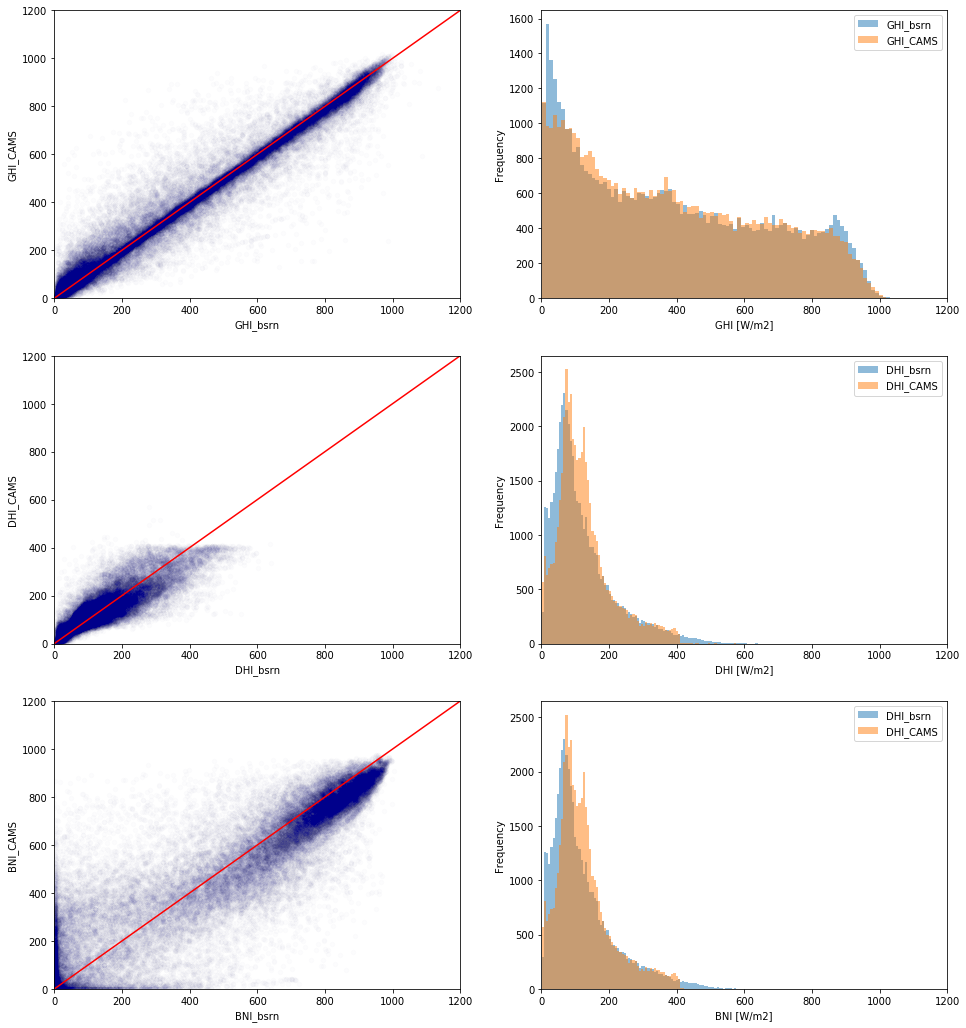

In [12]:
fig, axs = plt.subplots(3,2,figsize=(16,18))

g00=SolarDF_15min[index].plot.scatter(x="GHI_bsrn",y="GHI_CAMS",c='DarkBlue',alpha=0.01,ax=axs[0,0])
g00.plot([0,1200],[0,1200],color='r')
axs[0,0].set_xlim(0,1200)
axs[0,0].set_ylim(0,1200)

g10=SolarDF_15min[index].plot.scatter(x="DHI_bsrn",y="DHI_CAMS",c='DarkBlue',alpha=0.01,ax=axs[1,0])
g10.plot([0,1200],[0,1200],color='r')
axs[1,0].set_xlim(0,1200)
axs[1,0].set_ylim(0,1200)

g20=SolarDF_15min[index].plot.scatter(x="BNI_bsrn",y="BNI_CAMS",c='DarkBlue',alpha=0.01,ax=axs[2,0])
g20.plot([0,1200],[0,1200],color='r')
axs[2,0].set_xlim(0,1200)
axs[2,0].set_ylim(0,1200)

g01=SolarDF_15min[["GHI_bsrn","GHI_CAMS"]][index].plot.hist(bins=100, alpha=0.5,ax=axs[0,1])
axs[0,1].set_xlim(0,1200)
axs[0,1].set_xlabel("GHI [W/m2]")
g11=SolarDF_15min[["DHI_bsrn","DHI_CAMS"]][index].plot.hist(bins=100, alpha=0.5,ax=axs[1,1])
axs[1,1].set_xlim(0,1200)
axs[1,1].set_xlabel("DHI [W/m2]")
g21=SolarDF_15min[["DHI_bsrn","DHI_CAMS"]][index].plot.hist(bins=100, alpha=0.5,ax=axs[2,1])
axs[2,1].set_xlim(0,1200)
axs[2,1].set_xlabel("BNI [W/m2]")


### 6. Analysis of the joint distribution of  GHI, DHI and BNI using KDE and QQ plots

Visualisation of the joint distribution using KDE smoothers, marginal distribution and quantile-quantile relationship 

***

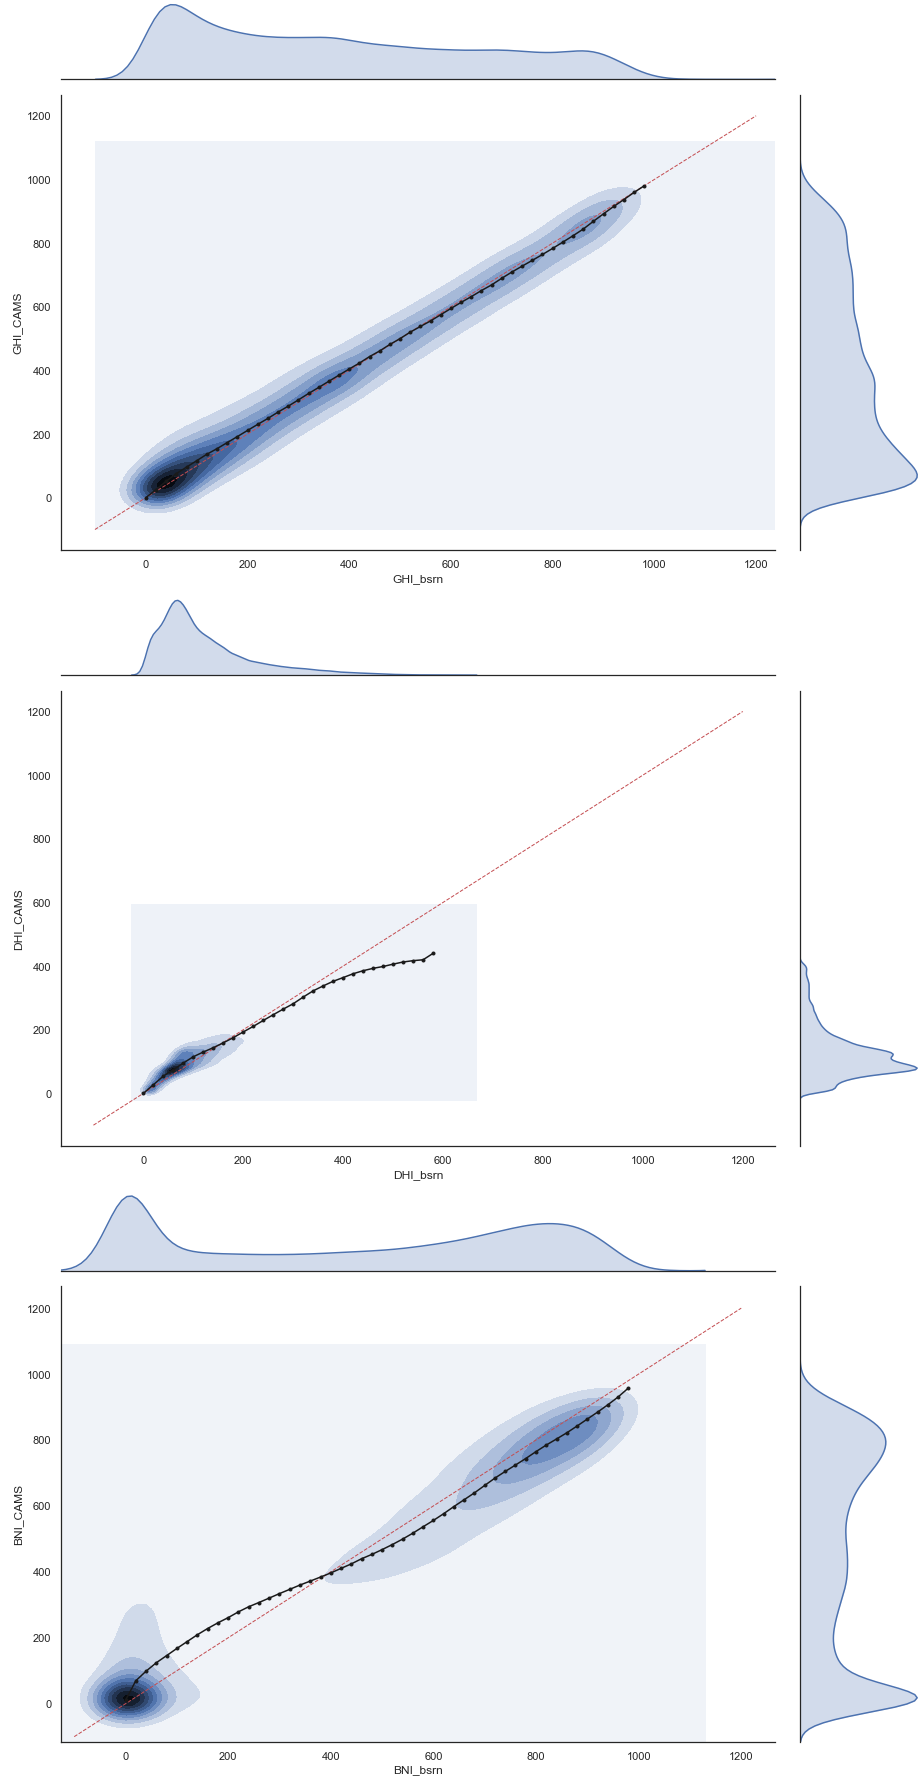

In [13]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns; sns.set()
sns.set_style("white")
import SeabornFig2Grid as sfg

    
g0=sns.jointplot(data=SolarDF_15min[index], x='GHI_bsrn', y='GHI_CAMS',kind='kde',space=0,n_levels=10)
g0.ax_joint.plot([-100,1200],[-100,1200], 'r--', linewidth = 1)
ecdf_cams = ECDF(SolarDF_15min[index].GHI_CAMS.values)
ecdf_bsrn = ECDF(SolarDF_15min[index].GHI_bsrn.values)
x=np.arange(0,1000,20)
Q=ecdf_bsrn(x)
y=np.interp(Q,ecdf_cams(x),x)
g0.ax_joint.plot(x,y,'k.-')

g1=sns.jointplot(data=SolarDF_15min[index], x='DHI_bsrn', y='DHI_CAMS',kind='kde',space=0,n_levels=10)
g1.ax_joint.plot([-100,1200],[-100,1200], 'r--', linewidth = 1)
ecdf_cams = ECDF(SolarDF_15min[index].DHI_CAMS.values)
ecdf_bsrn = ECDF(SolarDF_15min[index].DHI_bsrn.values)
x=np.arange(0,600,20)
Q=ecdf_bsrn(x)
y=np.interp(Q,ecdf_cams(x),x)
g1.ax_joint.plot(x,y,'k.-')

g2=sns.jointplot(data=SolarDF_15min[index], x='BNI_bsrn', y='BNI_CAMS',kind='kde',space=0,n_levels=10)
g2.ax_joint.plot([-100,1200],[-100,1200], 'r--', linewidth = 1)
ecdf_cams = ECDF(SolarDF_15min[index].BNI_CAMS.values)
ecdf_bsrn = ECDF(SolarDF_15min[index].BNI_bsrn.values)
x=np.arange(0,1000,20)
Q=ecdf_bsrn(x)
y=np.interp(Q,ecdf_cams(x),x)
g2.ax_joint.plot(x,y,'k.-')

fig = plt.figure(figsize=(13,25))
gs = gridspec.GridSpec(3, 1)

mg0 = sfg.SeabornFig2Grid(g0, fig, gs[0])
mg1 = sfg.SeabornFig2Grid(g1, fig, gs[1])
mg2 = sfg.SeabornFig2Grid(g2, fig, gs[2])

gs.tight_layout(fig)

plt.show()

### 7. Analysis of the joint distribution of  KT and Kb using KDE and QQ plots

Visualisation of the joint distribution using KDE smoothers, marginal distribution and quantile-quantile relationship 

***

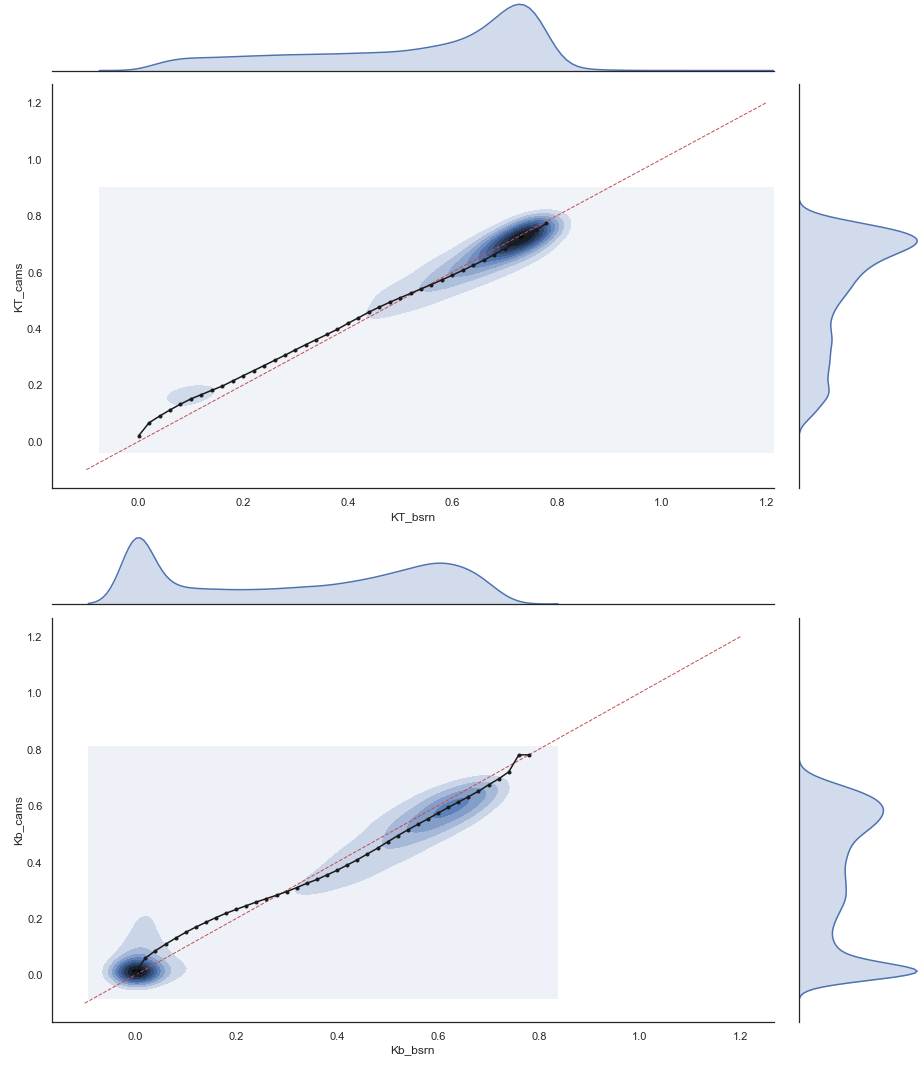

In [14]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns; sns.set()
sns.set_style("white")
import SeabornFig2Grid as sfg

    
g0=sns.jointplot(data=SolarDF_15min[index], x='KT_bsrn', y='KT_cams',kind='kde',space=0,n_levels=10)
g0.ax_joint.plot([-0.1,1.200],[-0.100,1.200], 'r--', linewidth = 1)
ecdf_cams = ECDF(SolarDF_15min[index].KT_cams.values)
ecdf_bsrn = ECDF(SolarDF_15min[index].KT_bsrn.values)
x=np.arange(0,0.8,0.02)
Q=ecdf_bsrn(x)
y=np.interp(Q,ecdf_cams(x),x)
g0.ax_joint.plot(x,y,'k.-')

g1=sns.jointplot(data=SolarDF_15min[index], x='Kb_bsrn', y='Kb_cams',kind='kde',space=0,n_levels=10)
g1.ax_joint.plot([-0.100,1.200],[-0.100,1.200], 'r--', linewidth = 1)
ecdf_cams = ECDF(SolarDF_15min[index].Kb_cams.values)
ecdf_bsrn = ECDF(SolarDF_15min[index].Kb_bsrn.values)
x=np.arange(0,0.8,0.02)
Q=ecdf_bsrn(x)
y=np.interp(Q,ecdf_cams(x),x)
g1.ax_joint.plot(x,y,'k.-')

fig = plt.figure(figsize=(13,15))
gs = gridspec.GridSpec(2, 1)

mg0 = sfg.SeabornFig2Grid(g0, fig, gs[0])
mg1 = sfg.SeabornFig2Grid(g1, fig, gs[1])

gs.tight_layout(fig)

plt.show()

### 8. Comparison of the clearness and beam clearness indices and their dependencies on the solar elevation angle
***
(Following an evaluation procedure from Pierre Ineichen.)

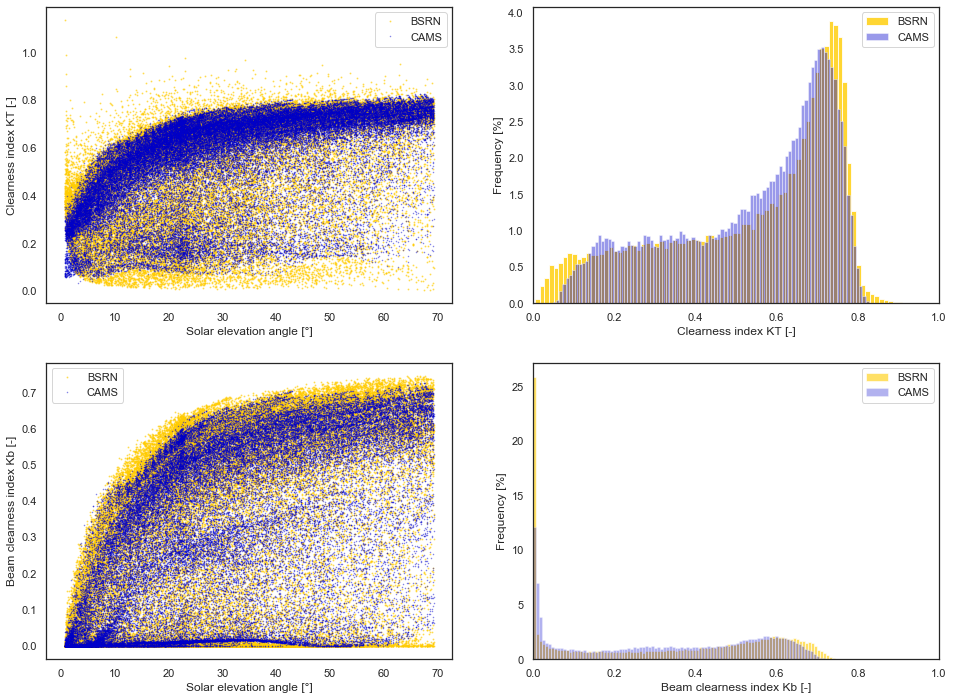

In [15]:
fig, axs = plt.subplots(2,2,figsize=(16,12))

axs[0,0].plot(SolarDF_15min.GammaS[index],SolarDF_15min.KT_bsrn[index],'.',color=[255/255,204/255,0],alpha=0.5,label='BSRN', markersize=2)
axs[0,0].plot(SolarDF_15min.GammaS[index],SolarDF_15min.KT_cams[index],'.',color=[0,0,0.8],alpha=0.5,label='CAMS', markersize=1)
axs[0,0].set_xlabel('Solar elevation angle [°]')
axs[0,0].set_ylabel('Clearness index KT [-]')
axs[0,0].legend()


axs[1,0].plot(SolarDF_15min.GammaS[index],SolarDF_15min.Kb_bsrn[index],'.',color=[255/255,204/255,0],alpha=0.5,label='BSRN', markersize=2)
axs[1,0].plot(SolarDF_15min.GammaS[index],SolarDF_15min.Kb_cams[index],'.',color=[0,0,0.8],alpha=0.5,label='CAMS', markersize=1)
axs[1,0].set_xlabel('Solar elevation angle [°]')
axs[1,0].set_ylabel('Beam clearness index Kb [-]')
axs[1,0].legend()

axs[0,1].hist(SolarDF_15min.KT_bsrn[index],bins=100,color=[255/255,204/255,0], alpha=0.8,label='BSRN',density =True)
axs[0,1].hist(SolarDF_15min.KT_cams[index],bins=100,color=[0,0,0.8], alpha=0.4,label='CAMS',density =True)
axs[0,1].set_xlim(0,1)
axs[0,1].set_xlabel('Clearness index KT [-]')
axs[0,1].set_ylabel('Frequency [%]')
axs[0,1].legend()

axs[1,1].hist(SolarDF_15min.Kb_bsrn[index],bins=100,color=[255/255,204/255,0], alpha=0.6,label='BSRN',density =True)
axs[1,1].hist(SolarDF_15min.Kb_cams[index],bins=100,color=[0,0,0.8], alpha=0.3,label='CAMS',density =True)
axs[1,1].set_xlim(0,1)
axs[1,1].set_xlabel('Beam clearness index Kb [-]')
axs[1,1].set_ylabel('Frequency [%]')
axs[1,1].legend()


### 9. Comparison of the daily maximal values
***
(Following an evaluation procedure from Pierre Ineichen.)

Text(0, 0.5, 'Maximum value of 15-min DNI over 5 days [W/m2]')

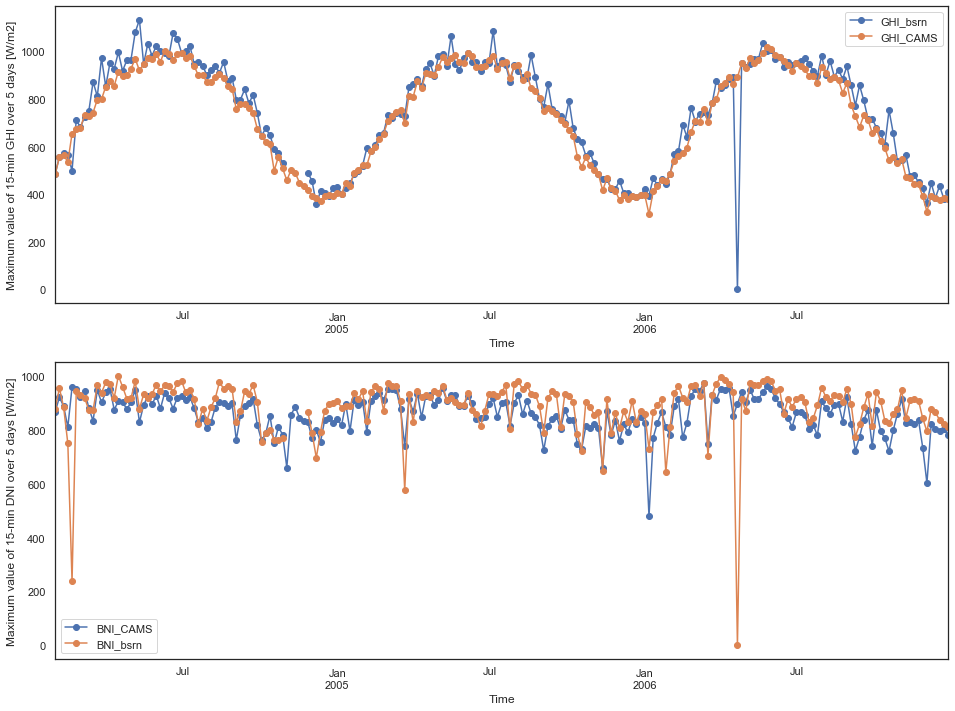

In [16]:
fig, axs = plt.subplots(2,1,figsize=(16,12))

SolarDF_15min[{'GHI_CAMS','GHI_bsrn'}].resample('5D').max().plot(ax=axs[0],marker='o')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Maximum value of 15-min GHI over 5 days [W/m2]')

SolarDF_15min[{'BNI_bsrn','BNI_CAMS'}].resample('5D').max().plot(ax=axs[1],marker='o')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Maximum value of 15-min DNI over 5 days [W/m2]')


### 10. Heatplot showing the dependence of the bias on the solar elevation and clearness index
***
(Following an evaluation procedure from Elke Lorenz)

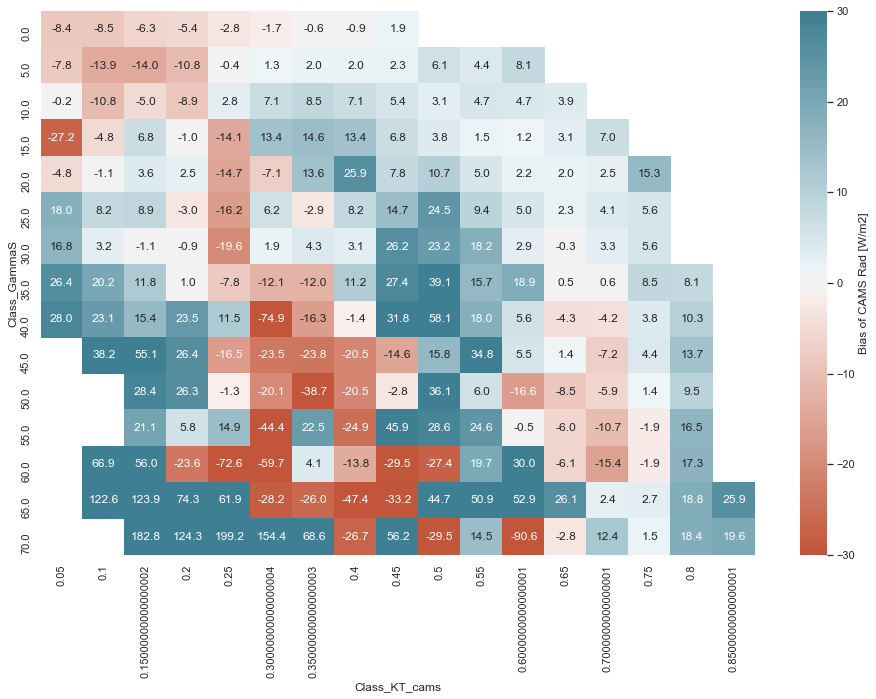

In [17]:
SolarDF_15min["dGHI_CAMS_BSRN"]=SolarDF_15min.GHI_CAMS-SolarDF_15min.GHI_bsrn
SolarDF_15min["dBNI_CAMS_BSRN"]=SolarDF_15min.BNI_CAMS-SolarDF_15min.BNI_bsrn
SolarDF_15min["Class_GammaS"]=np.round(SolarDF_15min["GammaS"]/5)*5
SolarDF_15min["Class_KT_cams"]=np.round(SolarDF_15min["KT_cams"]/0.05)*0.05

plt.figure(figsize = (16,10))
df = SolarDF_15min[index].pivot_table(index='Class_GammaS', columns='Class_KT_cams', values='dGHI_CAMS_BSRN', aggfunc=np.mean)
sns.heatmap(df, annot=True, fmt=".1f",vmin=-30, vmax=30, center=0,cmap=sns.diverging_palette(20, 220, n=200),square=False,\
           cbar_kws={'label': 'Bias of CAMS Rad [W/m2]'})
plt.show()
